# Link prediction with GCN

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

In this example, we use our implementation of the [GCN](https://arxiv.org/abs/1609.02907) algorithm to build a model that predicts citation links in the Cora dataset (see below). The problem is treated as a supervised link prediction problem on a homogeneous citation network with nodes representing papers (with attributes such as binary keyword indicators and categorical subject) and links corresponding to paper-paper citations. 

To address this problem, we build a model with the following architecture. First we build a two-layer GCN model that takes labeled node pairs (`citing-paper` -> `cited-paper`)  corresponding to possible citation links, and outputs a pair of node embeddings for the `citing-paper` and `cited-paper` nodes of the pair. These embeddings are then fed into a link classification layer, which first applies a binary operator to those node embeddings (e.g., concatenating them) to construct the embedding of the potential link. Thus obtained link embeddings are passed through the dense link classification layer to obtain link predictions - probability for these candidate links to actually exist in the network. The entire model is trained end-to-end by minimizing the loss function of choice (e.g., binary cross-entropy between predicted link probabilities and true link labels, with true/false citation links having labels 1/0) using stochastic gradient descent (SGD) updates of the model parameters, with minibatches of 'training' links fed into the model.

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

## Loading the CORA network data

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, _ = dataset.load(subject_as_feature=True)

In [5]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


## Testando g attr feature

In [9]:
g = nx.Graph()
g.add_edge("a", "b")
g.add_edge("b", "c")
g.add_edge("c", "d")
g.add_edge("d", "a")
# diagonal
g.add_edge("a", "c")

# square = StellarGraph.from_networkx(g)
# print(square.info())
# print('-'*100)

# square_named = StellarGraph.from_networkx(
#     g, node_type_default="paper", edge_type_default="cites")

# print(square_named.info())
# print('-'*100)
g_feature_attr = g.copy()


def compute_features(node_id):
    # in general this could compute something based on other features, but for this example,
    # we don't have any other features, so we'll just do something basic with the node_id
    return [ord(node_id), len(node_id)]


for node_id, node_data in g_feature_attr.nodes(data=True):
    node_data["feature"] = compute_features(node_id)

    
from stellargraph import StellarGraph
# let's see what some of them look like:
print(g_feature_attr.nodes["a"])
print(g_feature_attr.nodes["c"])
print('-'*100)
square_feature_attr = StellarGraph.from_networkx(g_feature_attr, node_features="feature")
print(square_feature_attr.info())

{'feature': [97, 1]}
{'feature': [99, 1]}
----------------------------------------------------------------------------------------------------
StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  default: [4]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [5]
        Weights: all 1 (default)
        Features: none


In [10]:
# Aime: vc pode adicionar mais umas 10 reviews aqui?
# Fonte: https://play.google.com/store/apps/details?id=com.ubercab&hl=en&gl=US
reviews = ['''The APP is good. But the services are continuously and gradually deteriorating due to the drivers and condition of the cabs. They are now at par with the old Taxi wallas, everytime either refusing the trips or ask us to cancel the trip. They also ask for payments in cash mode only. Some of them even ask for extra money.''',
        '''The app frequently stops working, but I've noticed it always happens after the first ride. So I'll take an uber someplace and think my account is okay, only to be unable to get a car when I really need one. It's happened enough that I think it's intentional. If the app disables my account when I'm home I'll just drive, but once I'm out the burden is on me to fix my uber account or find another way to get a ride home. So definitely do not depend on uber and make sure lyft works too.''',
        ''' This used to be a good service but not anymore. Had to edit my previous rating. Having problems with the service (a) There doesn't seem to be a set price. They seem to charge whatever they feel like. (b) drivers are sometimes rude. (c) They will just cancel the trip while you are waiting without communicating with you thus making you late and have to call another cab. I have more complaints but i think I'm out of space for this comment.I have started to call other taxi services instead of Uber.''',
        ''' The APP is good. But the services are continuously and gradually deteriorating due to the drivers and condition of the cabs. They are now at par with the old Taxi wallas, everytime either refusing the trips or ask us to cancel the trip. They also ask for payments in cash mode only. Some of them even ask for extra money. They are reluctant to put on the AC, etc...., etc....''',
        ''' The app is quite ok. But after a ride is scheduled, the driver will call to find out where you're going and if they don't want to do the trip, they make you wait for prolonged periods of time in the hopes of you cancelling the trip. Even when the location shows they're just down the street, they go the other way and make excuses, even 5 star rated drivers. Awful experiences so far''',
        ''' Rides are good, app keeps sending fake deal notifications though. For example, just received a notification for some deal where I just pay the delivery fee for a good delivery order and get the food for free. Tap on the notification, it just brings me to the home screen and I can't find the deal at all. This has happened before too. Bothering me with real deals is one thing, but sending fake promotions that go away the moment I tap them is atrocious.''',
        ''' Most of the time Uber is great, but the app is definitely more geared towards helping the drivers than the customers. Several times my driver has cancelled the ride before picking me up making me late for work. When the customer cancels they still have to pay full fare to the driver who is on the way. When the driver cancels nothing happens, you're just stuck waiting for a different driver who instead of being a few minutes away can be up to 15 away which makes you late.''',
        ''' App is gfeat but the only issue is they do not have any customer support available. If you get any issue with the driver. Driver will not get any plenty which is strange. Plus they started charging a lot of fares. And whenever you open the app it says fares are pretty high at the moment which sounds strange as it happens all the time''',
        ''' Lately I've been having the worst experience. Not once out of about ten rides have been on time. The drivers that match are about half hour away and it never shows the right time. More than once i have been waiting for on the road like an idiot. I booked a ride at 5.00 it came at 5.34. you guys are increasing your fleet and yet this is a repeated experience. You guys are lucky that there's no competition and you're taking full advantage of it. Worst experience. Rude drivers never on time.''',
        ''' I dont know about you, but I dont wanna pay $30 for a estamated 5 min trip. I thought this was cool but the prices are unfair. A 30 min trip to the mall costs the same price, really? Compared to 5 mins? No, I dont know how they've been in service this long but this isnt fair. Id rather wait 2 hours in pitch black for a bus ride home then to pay a day for this junk.''',
        ''' Since some time ago I noticed that is more difficult to find a car, when I am trying to go to the aeroport or any place that is far away, the driver told me that they cancelled because the app take a big amount of the payment as the longer the distance is. I don't know if is true but I highly recommend to find a solution. Today I got five times cancelled and 30 minutes waste finally in Didi I found a car''',
        ''' It used to be a very good cab service provider. But in recent times I am struggling with every ride. Drivers cancel rides most of the times after getting to know destination. And many of them cancel intentionally and ask to pay the same amount in cash to them and drive us without uber knowledge and no tracking!! Also cost is charged for a longer routes and when we ride a shorter route is shown. Of the concern is raised no proper response from uber team. Worst service now a days..!''']

In [11]:
from knowledgeGraph import get_entity

ModuleNotFoundError: No module named 'knowledgeGraph'

In [12]:
import nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import networkx as nx

KG = nx.Graph()
source = []
target = []

for review in reviews:
  for sentence in sent_tokenize(review):
    # print(sentence)
    nodes = get_entity(sentence)
    relation = get_relation(sentence)
    # print(nodes,relation)
    node1 = nodes[0]
    node2 = nodes[1]
    if len(node1) > 0 and len(node2) > 0:
      KG.add_edge(node1,node2,relation=relation)
      source.append(node1)
      target.append(node2)

print(source)
print(target)

[nltk_data] Downloading package punkt to /home/aime/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


NameError: name 'get_entity' is not defined

In [ ]:
data_edges = {'source': source, 'target': target}
df_edges = pd.DataFrame(data_edges)
df_edges.head(5)

### Loading test.csv

In [13]:
import csv

def write_file(filename, list_edges, header):
    
    csvFile = open(filename, 'a')
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(header)
    
    for node in range(len(list_edges)):
        start = list_edges[node]['start']['label']
        end = list_edges[node]['end']['label']
#         rel = list_edges[node]['rel']['label']
        weight = list_edges[node]['weight']

#         info_edge = [start, rel, end, weight]
        info_edge = [start, end, weight]
        
        csvWriter.writerow(info_edge)
    
# header = ['start', 'rel', 'end', 'weight']
header = ['source', 'target', 'weight']
write_file('test.csv', var, header)

import networkx as nx
import pandas as pd

df = pd.read_csv('test.csv')
G = StellarGraph(edges = df)

NameError: name 'var' is not defined

In [20]:
print(G.info())
G

StellarGraph: Undirected multigraph
 Nodes: 4, Edges: 5

 Node types:
  default: [4]
    Features: float32 vector, length 2
    Edge types: default-default->default

 Edge types:
    default-default->default: [5]
        Weights: all 1 (default)
        Features: none


In [11]:
# importing networkx
import networkx as nx
 
# importing matplotlib.pyplot
import matplotlib.pyplot as plt

In [22]:
G= nx.read_edgelist(G, nodetype=int, data=(('weight',float),))

TypeError: 'StellarGraph' object is not iterable

We aim to train a link prediction model, hence we need to prepare the train and test sets of links and the corresponding graphs with those links removed.

We are going to split our input graph into a train and test graphs using the EdgeSplitter class in `stellargraph.data`. We will use the train graph for training the model (a binary classifier that, given two nodes, predicts whether a link between these two nodes should exist or not) and the test graph for evaluating the model's performance on hold out data.
Each of these graphs will have the same number of nodes as the input graph, but the number of links will differ (be reduced) as some of the links will be removed during each split and used as the positive samples for training/testing the link prediction classifier.

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [21]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

IndexError: single positional indexer is out-of-bounds

In [ ]:
train_test_split?

The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [23]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

NameError: name 'G_test' is not defined

G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

## Creating the GCN link model

Next, we create the link generators for the train and test link examples to the model. The link generators take the pairs of nodes (`citing-paper`, `cited-paper`) that are given in the `.flow` method to the Keras model, together with the corresponding binary labels indicating whether those pairs represent true or false links.

The number of epochs for training the model:

In [24]:
epochs = 50

For training we create a generator on the `G_train` graph, and make an iterator over the training links using the generator's `flow()` method:

In [25]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

NameError: name 'G_train' is not defined

In [26]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

NameError: name 'G_test' is not defined

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.3` specifies a 30% dropout at each layer. 

We create a GCN model as follows:

In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=train_gen, dropout=0.3
)

To create a Keras model we now expose the input and output tensors of the GCN model for link prediction, via the `GCN.in_out_tensors` method:

In [12]:
x_inp, x_out = gcn.in_out_tensors()

Final link classification layer that takes a pair of node embeddings produced by the GCN model, applies a binary operator to them to produce the corresponding link embedding (`ip` for inner product; other options for the binary operator can be seen by running a cell with `?LinkEmbedding` in it), and passes it through a dense layer:

In [13]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

The predictions need to be reshaped from `(X, 1)` to `(X,)` to match the shape of the targets we have supplied above.

In [14]:
prediction = keras.layers.Reshape((-1,))(prediction)

Stack the GCN and prediction layers into a Keras model, and specify the loss

In [15]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=0.01),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

/home/aime/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Evaluate the initial (untrained) model on the train and test set:

In [16]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 96ms/step - loss: 1.5849 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 1.5461
	binary_accuracy: 0.5010

Test Set Metrics of the initial (untrained) model:
	loss: 1.5849
	binary_accuracy: 0.5000


Train the model:

In [17]:
history = model.fit(
    train_flow, epochs=epochs, validation_data=test_flow, verbose=2, shuffle=False
)

Epoch 1/50
1/1 - 2s - loss: 1.4650 - binary_accuracy: 0.5010 - val_loss: 2.5933 - val_binary_accuracy: 0.5221
Epoch 2/50
1/1 - 0s - loss: 2.3953 - binary_accuracy: 0.5277 - val_loss: 0.9568 - val_binary_accuracy: 0.5664
Epoch 3/50
1/1 - 0s - loss: 1.0865 - binary_accuracy: 0.6199 - val_loss: 0.7276 - val_binary_accuracy: 0.5812
Epoch 4/50
1/1 - 0s - loss: 0.6451 - binary_accuracy: 0.6465 - val_loss: 0.8062 - val_binary_accuracy: 0.5489
Epoch 5/50
1/1 - 0s - loss: 0.7238 - binary_accuracy: 0.5861 - val_loss: 0.7770 - val_binary_accuracy: 0.5600
Epoch 6/50
1/1 - 1s - loss: 0.6991 - binary_accuracy: 0.6219 - val_loss: 0.7006 - val_binary_accuracy: 0.6042
Epoch 7/50
1/1 - 0s - loss: 0.6316 - binary_accuracy: 0.6496 - val_loss: 0.7510 - val_binary_accuracy: 0.6245
Epoch 8/50
1/1 - 0s - loss: 0.6266 - binary_accuracy: 0.6742 - val_loss: 0.9288 - val_binary_accuracy: 0.6089
Epoch 9/50
1/1 - 0s - loss: 0.8871 - binary_accuracy: 0.6762 - val_loss: 0.8310 - val_binary_accuracy: 0.6245
Epoch 10/5

Plot the training history:

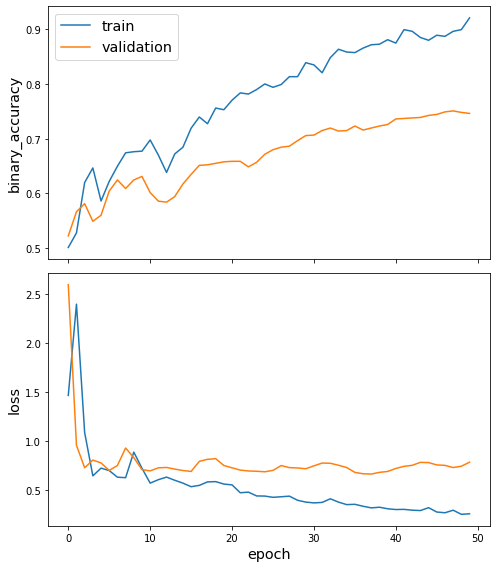

In [18]:
sg.utils.plot_history(history)

Evaluate the trained model on test citation links:

In [19]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 58ms/step - loss: 0.7843 - binary_accuracy: 0.7463

Train Set Metrics of the trained model:
	loss: 0.1924
	binary_accuracy: 0.9385

Test Set Metrics of the trained model:
	loss: 0.7843
	binary_accuracy: 0.7463


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/gcn-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>